In [ ]:
import pandas as pd
import seaborn

In [ ]:
path_df = "/content/drive/MyDrive/1C2024/OrgaDeDatos/Copia de properati_argentina_2021.csv"

In [ ]:
df = pd.read_csv(path_df)

In [ ]:
df.shape

(460154, 20)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460154 entries, 0 to 460153
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        460154 non-null  object 
 1   start_date                460154 non-null  object 
 2   end_date                  460154 non-null  object 
 3   created_on                460154 non-null  object 
 4   latitud                   419740 non-null  float64
 5   longitud                  419740 non-null  float64
 6   place_l2                  460154 non-null  object 
 7   place_l3                  437665 non-null  object 
 8   place_l4                  139020 non-null  object 
 9   place_l5                  2430 non-null    object 
 10  place_l6                  0 non-null       float64
 11  operation                 460154 non-null  object 
 12  property_type             460154 non-null  object 
 13  property_rooms            368498 non-null  f

In [ ]:
df.head(3)

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
0,XZq2dFGxBiboHY3Bo/tqlw==,2021-09-09,2022-01-27,2021-09-09,-38.957632,-68.105443,Neuquén,NaN,NaN,NaN,NaN,Venta,Casa,6.0,NaN,NaN,206.0,NaN,NaN,Casa - Capital
1,8afoK+yMH/rnnlYiktwgNA==,2021-09-09,2021-10-23,2021-09-09,-34.888878,-56.092368,Montevideo,NaN,NaN,NaN,NaN,Venta,Casa,4.0,3.0,193.0,193.0,390000.0,USD,Casa - Malvín
2,iVaG5rBB47dd1Ya4BMXREA==,2021-09-09,2022-03-09,2021-09-09,-32.488717,-58.257499,Entre Ríos,NaN,NaN,NaN,NaN,Venta,Casa,NaN,NaN,110.0,45.0,47000.0,USD,Casa - Uruguay


In [ ]:
df.isnull().sum()

id                               0
start_date                       0
end_date                         0
created_on                       0
latitud                      40414
longitud                     40414
place_l2                         0
place_l3                     22489
place_l4                    321134
place_l5                    457724
place_l6                    460154
operation                        0
property_type                    0
property_rooms               91656
property_bedrooms           116041
property_surface_total       62341
property_surface_covered     32238
property_price               18001
property_currency            18564
property_title                   0
dtype: int64

Veo que en place_l6 literalmente **todas** las filas tienen valor NaN

In [ ]:
df = df.drop("place_l6", axis=1)

Me fijo si todas las propiedades del dataset corresponden a casas en venta

In [ ]:
df["operation"].value_counts()

Venta                337874
Alquiler              98900
Alquiler temporal     23380
Name: operation, dtype: int64

Aquellos valores que no son de venta deberia descartarlos ? (yo creeria que si)

<ipython-input-30-4417406ae8bf>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  seaborn.heatmap(df.corr(), annot = True)


<Axes: >

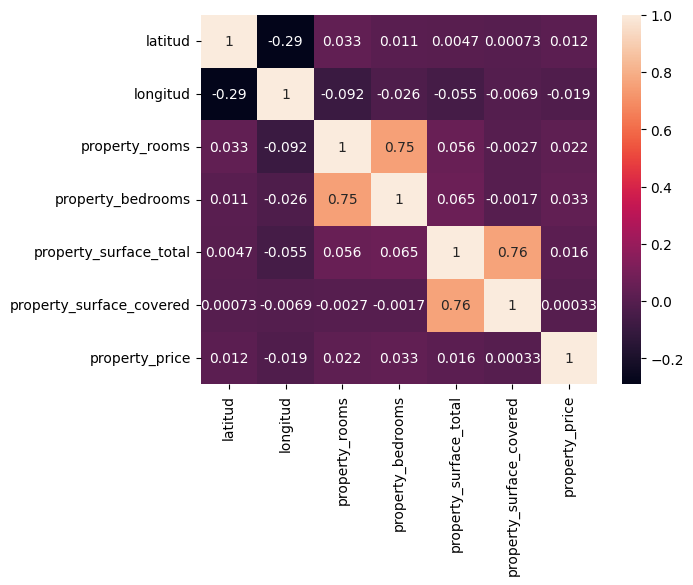

In [ ]:
seaborn.heatmap(df.corr(), annot = True)